# Anomaly detection with Python


Suppose we are working as a (clinical) data analyst for some medical organization close to a GP. One day we are given a moderate in size dataset of our patients. Staff has been collecting some six quantifiable features, be it symptoms or tests, that are indicative (to a limited extend) or suggest a **hypothyroidism** - "a condition in which the thyroid gland doesn't produce enough thyroid hormone". Data also has labels stating whether patient actually was hypothyroid.  

( You can download some example [Thyroid Disease Dataset](http://odds.cs.stonybrook.edu/thyroid-disease-dataset/) available through [Outlier Detection DataSets (ODDS)](http://odds.cs.stonybrook.edu/)) 


We are not running a thyroid diagnosis and treatement center, but are a part of first contact team. For doctors it would be nice to build some model that detects anomalies in patients, so further efforts might focus on specific organs or targeted diagnostics. Say, patient visits a GP, goes over symptoms and has a set of basic tests and measurements. Given our data we can't really tell whether this patient is or is not hypothyroid, but rather whether there is some significant abnormality in a set of his results that, given small historical data, we may want to send him or her to check specifically for thyroid. 


Our dataset is relatively small and skewed as most patients do not have hypothyroidis. This limits us directly in using "state of the art", everyone's favourite neural net classification system. However we can try working with this data and construct an *anomaly detection system*.

Anomaly detection is a problem from Machine Learning. Its motivation is simple: given a new example we want to state whether it is coming from the same distribution as the majority of the data we have or not, i.e. is anomalous. This problem is quite different from standard classification examples, as we have disproportionately more negative examples than positive. Here negative and positive are used to indicate accordingly non-anomalous and anomalous.

Often gathered datasets are multidimensional, and visualizing them on a plane or in 3D may not be enough. Sure, for exploratory analysis it might be worthwhile to perform dimensionality reduction through PCA, but we need to model appropriately our dataset.


The idea is simple. We model each feature of our dataset by a multivariate Gaussian distribution: compute mean ($\mu$) and variance ($\sigma^2$). 

# Exploring our data

Before proceeding, make sure we have necessary packages:
- Scipy
- Numpy
- Matplotlib
- Pyplot (optional; for later visualizations)

In [143]:
import numpy as np
import scipy.io,scipy.stats,scipy

## Download and load given dataset

Now we can download [Thyroid Disease Dataset](http://odds.cs.stonybrook.edu/thyroid-disease-dataset/) available through [Outlier Detection DataSets (ODDS)](http://odds.cs.stonybrook.edu/):

In [1]:
!wget https://www.dropbox.com/s/bih0e15a0fukftb/thyroid.mat

--2018-05-08 19:18:11--  https://www.dropbox.com/s/bih0e15a0fukftb/thyroid.mat
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/mw9IJMmNXNgAIknfNcd0qWCb7R7UWT4yk7mND0bmo4Silygx37N33NlycMzq4KcJ/file [following]
--2018-05-08 19:18:12--  https://dl.dropboxusercontent.com/content_link/mw9IJMmNXNgAIknfNcd0qWCb7R7UWT4yk7mND0bmo4Silygx37N33NlycMzq4KcJ/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.8.6, 2620:100:6018:6::a27d:306
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.8.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39704 (39K) [application/octet-stream]
Saving to: ‘thyroid.mat’

thyroid.mat         100%[===================>]  38.77K  --.-KB/s    in 0.02s   

2018-05-08 19:18:13

Then we need to load a $.mat$ file specific for a MATLAB/Octave environment.

In [144]:
data = scipy.io.loadmat('thyroid.mat')
X=data['X']
y=data['y']
y=y.flatten()
y=y.astype(int)
print('Data set sizes: \n input X: %s \n labels y: %s ' % ( str(np.shape(X)),str(np.shape(y)) ))

Data set sizes: 
 input X: (3772, 6) 
 labels y: (3772,) 


Our data has 3772 patients. We have $\hat y$ labels $\in \{0,1\}$ and features. 

$$ X = \{ (x^{n}_1, y_1), ... , (x^{n}_m, y_m)    \}    $$



## Check basic characteristics

In [145]:
classes = np.unique(y,return_counts=True) # we make sure we have only two labels
classes

(array([0, 1]), array([3679,   93]))

We know that labels either contain zero or one. We now know that we have 3679 negative examples (normal, healthy people) and 93 hypothyroid patients. The hyperfunction class is treated as outlier class (1) and the rest are inliers (0). This is because hyperfunction is a clear minority class. 

This is where we clearly see that classes are skewed. The overwhelming majority...

In [146]:
round(classes[1][0]/sum(classes[1][:])*100,1)

97.5

97.5% are negative classes (healthy), the remaining 2.5% are positive classes (hyperfunction). 

(*It is worth noticing that the dataset description on [ODDS](http://odds.cs.stonybrook.edu/thyroid-disease-dataset/) states that `healthy` actually refers to a mix of two classes, normal functioning thyroid and some hyperfunction. We are clearly limited here by the nature of this dataset, however still can successfully construct a model  *)

## Splitting dataset

Before proceeding with model building we need to reasonably split the dataset for training, cross-validation and model testing. The surprising idea is that for model training we use only negative examples. Since we want to model each feature with Gaussian distribution, it would be appropriate to `train` our model on negative examples, and use a smaller portion of positive examples for hyperparameter tuning ($\epsilon$) and model testing. 

Table below shows how one might approach it:

|Sets | # Negative examples | # Positive examples | 
| ---| --- | --- |
| Train set| 2999 | 0 |
| Cross-validation set| 340 | 46 |
| Test set| 340 | 47 |



Below is just a very simple code. `For` loop could be used since in this example we are not dealing with "Big Data", and can easily work on a local machine: 

In [147]:
X_positives=[] # the minority of data - hypothyroid patients
Y_positives=[]
X_negatives=[] # the majority of data - healthy subjects
Y_negatives=[] 


# Loop over dataset and split 'negatives' and 'positives' accordingly

for i in range(0, X.shape[0]):
    if y[i]==0: 
        X_negatives.append(X[i])
        Y_negatives.append(y[i])
    elif y[i]==1:
        X_positives.append(X[i])
        Y_positives.append(y[i])
    else:
        print("Labelling error occured")
        
        
# Subset dataset according to a table above
X_train = X_negatives[:2999]
Y_train = Y_negatives[:2999]

X_CV = X_negatives[2999:(2999+340)] + X_positives[:46]
Y_CV = Y_negatives[2999:(2999+340)] + Y_positives[:46]

X_test= X_negatives[2999+340:] +  X_positives[46:]
Y_test= Y_negatives[2999+340:] + Y_positives[46:]

####

# Convert from lists to numpy arrays
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

X_CV = np.asarray(X_CV)
Y_CV = np.asarray(Y_CV)

X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

In [148]:
# Make sure that lenghts of our datasets 'add up'
X.shape[0] == len(X_train)+ len(X_CV)+len(X_test)

True

In [149]:
# Make sure that lenghts of our datasets 'add up'
y.shape[0] == len(Y_train)+ len(Y_CV)+len(Y_test)

True

Good, our detaset is in a good shape for train, validation and final accuracy measures. 

# Building a model

As stated in the beginning the idea here is very simple. We model the distribution of our data (from training set) by Gaussian distribution. For this we need to compute mean $\mu^i$ and variance $\sigma^i$ for each feature $i$. We can do it easily operating on matrices - i.e. *vectorized implementation*. 



In [150]:
MU = np.mean(X_train,axis=0)
SIGMA2= np.var(X_train,axis=0) #Squared sigma - variance

In [151]:
print(MU.shape,SIGMA2.shape) # for each feature we have appropriate mean and variance.

(6,) (6,)


# Selecting threshold $\epsilon$

Here is the main idea of the basic 'anomaly detection system'. Having computed mean and variance for a training set for each of the features, we can now compute probability for a given example. If this probability is 'low' we flag it as anomaly, if the computed probability is 'high' we determine that this example is non-anomalous. 

We compute probability for a given example $x^{i}$ by:

$$ f_x(x^{i}_1,...,x^{i}_n) = \frac{exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1}(x-\mu)} {\sqrt{2\pi^n \cdot |\Sigma|} }   $$

where:
- $\Sigma $ - covariance matrix
- $ |\Sigma| $ - determinant of covariance matrix
- $\mu$ - vector of mean values of each feature in a dataset
- $\Sigma$ - vector of variances of each feature in a dataset
- $n$ - number of features


However how to tell what probability is 'low enough' for a given example to be flagged as anomalous? Here we can use our cross-validation set that has some positive (anomalous) examples. 

The first step involves computing the probabilities, or rather a vector of probabilities for each example and for each feature. We can use scipy implementation like this:

In [152]:
from scipy.stats import multivariate_normal
PDF = multivariate_normal.pdf(X_CV,mean=MU, cov=np.diag(SIGMA2))

Here we compute PDF (Probability Density Function), that is just an integral over the values of the distribution up to a given $X_{CV}$ point. 

The next step is to write a function that takes your $\hat{y}_{CV}$ labels and $PDF$ estimates for $X_{CV}$ and selects a threshold $\epsilon$. 

This $\epsilon$ would be a threshold probability below which given example would be categorized as anomalous. To pick this best $\epsilon$ we'd iteratively loop over some range of possible values, from $min(PDF)$ to $max(PDF)$, with a specified step or number of in-between values. For each this $\epsilon$ we'de compute $F1$ score defined by precision and recall (check [wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall) for more explainations).



In [153]:
def SelectThreshold(Y_CV,PDF,linespacing=2500):
    
    assert(len(Y_CV)==len(PDF))
    
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0

    for epsilon in np.linspace(min(PDF),max(PDF),num=linespacing): #num - number of steps

        # Y_CV says it's an anomaly and so algorithm does.
        tp = sum((Y_CV==1) & (PDF < epsilon)) # True Positives
        
        # Y_CV says it's not an anomaly,  but algorithm says anomaly.
        fp = sum((Y_CV==0) & (PDF<epsilon)) # FALSE POSITIVES
        
        #Y_CV says it's an anomaly,  but algorithm says not anomaly.
        fn = sum((Y_CV==1) & (PDF>=epsilon))
        
    
        # precision and recall
        prec = tp/(tp+fp)
        rec = tp/(tp+fn)

        # F1 value;
        F1 = (2*prec*rec)/(prec+rec)
        
        if (F1 > bestF1):

            bestF1 = F1
            bestEpsilon = epsilon

    return bestEpsilon, bestF1

In [154]:
bestEpsilon, bestF1 = SelectThreshold(Y_CV,PDF)
bestEpsilon, bestF1

/home/robert_kwapich/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in long_scalars



(124.91548113494866, 0.7678571428571428)

From above we see two values:

1. $bestEpsilon$ - contains the value estimated to perform best on a cross-validation dataset.  
2. $bestF1$ - contains the best F1 score achieved for this problem. 

As we can see, the value is $\approx 0.77$, which is not outstanding in general, but given the skewed data, it is still good. However, since we 'hand-picked' this value on cross-validation set, it is not a reliable measure of our model. We need to test it on the thirds withheld dataset - the test set.

# Testing model

Having picked the best suiting $\epsilon$ we can now validate the model. The same reasoning follows: we compute F1 Score, precision, recall but this time on test set.

In [341]:
TEST_PDF = multivariate_normal.pdf(X_test,mean=MU, cov=np.diag(SIGMA2))
# Y_test says it's an anomaly and so algorithm does.
tp = sum((Y_test==1) & (TEST_PDF < bestEpsilon)) # True Positives

# Y_test says it's not an anomaly,  but algorithm says anomaly.
fp = sum((Y_test==0) & (TEST_PDF<bestEpsilon)) # FALSE POSITIVES

# Y_test says it's an anomaly,  but algorithm says not anomaly.
fn = sum((Y_test==1) & (TEST_PDF>=bestEpsilon))


# precision and recall
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# F1 value;
F1 = (2*prec*rec)/(prec+rec)

F1

0.7258064516129032

In [157]:
prec

0.5844155844155844

In [158]:
rec

0.9574468085106383

So our model has $F1\approx0.73$. This is not ideal, however given the dataset and the scope of its future use (suggesting not correctly classifying, as we clearly do not have enough data for classification), it is good.

Bear in mind that predicting $y=0$ all the time for such a skewed dataset would yield a high *'accuracy'*. As we'd only classify wrongly 93 out of 3772 and that would give us **97.53%** accuracy. And of course, this is not a solution. We do want to catch some anomalies if they likely occur. We'd be more happy even if we traded some of the precision for a recall.

Our model has high recall, which mean we very well identify all anomalies. So we are "good" at catching anomalies in patients when they occur, however when you look at our precision score, it low. Precision essentially measures how well (precisely) our model identifies anomalies. I.e. our low score indicates that model will produce an "alert" even is some patient might not be hypothyroid.

#### Is this good? 

Given the skewed dataset, and serious lack of *positive* examples I'd say it is helpful. When a new patients comes in, we perform a given set of basic tests, and a model predicts that he or she *might be* hypothyroid, we just sent this patient for a detailed set of tests that are more *precise* (or *sensitive*). This is not a serious decision on performing a complicated operation relying on our system. But at the same time we make sure that we are catching $\approx 96\%$ of anomalies, as our *recall* score indicates. 

Oftentimes building a model and estimating *accuracy* is not enough. We have to analyze the nature of the problem, nature of given data. Here, a simple overview of precision, recall and F1 score gave us insight and model interpretation.

# Making a prediciton

Finally, we can of course take the model and apply it to our data. Making a prediciton is easy, you flag an example as anomalous if $ PDF[Example] < Epsilon$, otherwise the prediction says is a normal example.


Let's use some examples from the *test* set.

In [159]:
good_example = multivariate_normal.pdf(X_negatives[-1],mean=MU, cov=np.diag(SIGMA2))
anomalous_example = multivariate_normal.pdf(X_positives[-1],mean=MU, cov=np.diag(SIGMA2))

In [160]:
if good_example>bestEpsilon:
    print("Non-anomalous Example Predicted as non-anomalous. ")
    

Non-anomalous Example Predicted as non-anomalous. 


In [161]:
if anomalous_example<bestEpsilon:
    print("Anomalous example Predicted as anomalous")
    

Anomalous example Predicted as anomalous


# Visualizations

Given high dimensionality of our dataset visualizing it is not a straightforward procedure. Sure, you can take first two features and plot, but this visualization would omit the rest of the features. The solution in [Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis), which I won't describe here in detail. 

The key idea is that we can *reduce dimensionality* of our dataset while retaining some substantial part of variance in the data. As some features in our data might highly correlate (i.e. might be redundant), i.e. BMI and height, they can be represented by an arbitrary one number. 

Before proceeding with PCA we need to perform *feature normalization*: from a dataset subtract mean and divide by variance:

## PCA

### Feature normnalization

We normalize the entire dataset by the means of substracting mean and dividing by variance:

$$X:= \frac{X-\mu}{\sigma^2}$$

In [162]:
MU_all = np.mean(X,axis=0)
MU_all.shape 

(6,)

In [163]:
SIGMA2_all= np.var(X,axis=0) #Squared sigma - variance
SIGMA2_all.shape

(6,)

In [164]:
X_norm_all = (X - MU_all ) / SIGMA2_all

In [165]:
m = X_norm_all.shape[0] #number of examples

### Covariance matrix and eigenvectors

The standard procedure is to compute a covariance matrix $\Sigma = \frac{1}{m} \Sigma^{n}_{i=1} x^{(i)}(x^{(i)})^T$.

In [166]:
Covariance_Matrix = (1/m)* np.cov(np.transpose(X_norm_all))

In [167]:
Covariance_Matrix.shape

(6, 6)

The next step is to use an 'SVD' function. SVD stands for Singular Value Decomposition. I won't go into details, but here we just need eigenvector $U$ of a matrix $\Sigma$ (covariance matrix). This is fortunately implemented in numpy

In [168]:
u, s, vh = np.linalg.svd(Covariance_Matrix, full_matrices=True)

In [169]:
u.shape

(6, 6)

### Reducing to K-dimensions

We want to reduce $N$ dimensions of our dataset to $K$ dimensions, where $K\leq N$. 

This is simply done by subsetting our eigenvector matrix $U$. Our "reduced" values would be stored in a new variable $Z$ of shape $(m,K)$, where $m$ - number of examples in our dataset $K$ - new, reduced dimensionality:

In [180]:
K=2
u_reduce = u[:,:K]
Z = np.zeros((X_norm_all.shape[0],K))
Z.shape

(3772, 2)

Multiplying our reduced matrix `U_reduce` by each example gives us its reduced representation:

In [181]:
for i in range(0,X_norm_all.shape[0]): #going over each example and reducing the dimensionality
    Z[i,:] = np.dot(u_reduce.T,X_norm_all[i])
    
X1_points= Z[:,0]
X2_points=Z[:,1]

We can now proceed to plot our points on a 2D plane. Our truth $\hat{y}$ labels are helpful in labeling.

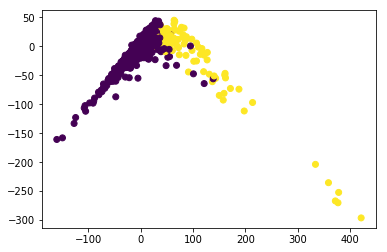

In [173]:
import matplotlib.pyplot as plt
import pylab
pylab.scatter(X1_points, X2_points, c=y)

### Estimating the quality of the reduction

We want to have a metric number conveying the *quality* of the PCA. In other words what percentage of variance is retained in the reduced representation. The first step of this estimation is to reconstruct our data from reduced representation, and then usting simple square root distance estimate the percentage. 

First, let's focus on reconstructing our data. In order to do this, we follow a simple matrix multiplication:

$$ X_{approx} = u_{reduce} \cdot Z \approx X_{original}$$

In [174]:
X_reconstructed = np.dot(Z, u_reduce.T)

Just checking if the matrices have the same sizes

In [175]:
X_reconstructed.shape==X.shape

True

We want our reduction (a.k.a. projection) to minimize averaged square error projection erro:

$$ \frac{1}{m} \Sigma^{m}_{i=1} || x^{(i)} - x_{approx}^{(i)}  ||^2  $$

The total variation in the data is given by:

$$ \frac{1}{m} \Sigma^{m}_{i=1}  ||x^{(i)}||^2 $$


Now, we can divide the former by the latter. The smaller the number the more variance retained:

$$ \frac{\frac{1}{m} \Sigma^{m}_{i=1} || x^{(i)} - x_{approx}^{(i)}  ||^2}{\frac{1}{m} \Sigma^{m}_{i=1}  ||x^{(i)}||^2}  \leq 0.01 = 1\% $$

Usually the very good reduction loses small amount of variance. The amount of retained variance is just `1` minus the above:

$$ 1 -  \frac{\frac{1}{m} \Sigma^{m}_{i=1} || x^{(i)} - x_{approx}^{(i)}  ||^2}{\frac{1}{m} \Sigma^{m}_{i=1}  ||x^{(i)}||^2}  \geq 99\% $$

And this is the exact thing we are going to compute for our 2D projection. Remember that we used PCA for a *normalized* dataset, therefore we have to compare the reconstructed version to a normalized. The other way would be to compare original data with reconstructed data corrected for its initial mean and variance.

In [176]:
(1- (np.sum(np.power((X_reconstructed-X_norm_all),2))/np.sum(np.power((X_norm_all),2))))*100

74.32962581712485

So our 2D reduction (from 6D dataset) contains around $74\%$ of the data variance. Not ideal, but still not bad. In highly complex datasets, such as taxonomic profiles of the gut microbiota from several patients, the dimensionalities of microbial distances on the tree of life reach hundreds if not thousands, and PCoA plots (*a slight variation*) sometimes retain around $13\% - 50\%$ of our data. 



But nothing is lost! We can also successfuly visualize our dataset in 3 dimensions. So I am going to repeat some of the above computations in one shot, the difference is only `K=3` and the variable names:

In [184]:
K_new=3
u_reduce_3D = u[:,:K_new]
Z_3D = np.zeros((X_norm_all.shape[0],K_new))

for i in range(0,X_norm_all.shape[0]): #going over each example and reducing the dimensionality
    Z_3D[i,:] = np.dot(u_reduce_3D.T,X_norm_all[i])
    
X1_3d= Z_3D[:,0]
X2_3d=Z_3D[:,1]
X3_3d=Z_3D[:,2]

X_reconstructed_3D = np.dot(Z_3D, u_reduce_3D.T)
assert(X_reconstructed_3D.shape==X.shape)

(1- (np.sum(np.power((X_reconstructed_3D-X_norm_all),2))/np.sum(np.power((X_norm_all),2))))*100

91.057557559864

$\approx 91\%$! This is certainly more satisfying than 2D projection. Let's plot this using matlab:

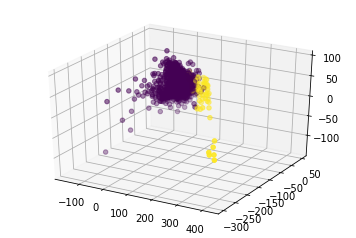

In [185]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=X1_3d, ys=X2_3d, zs=X3_3d,c=y)

Unfortunatley, its not interactive. That's why I prefer plotly:

In [186]:
import plotly as py
API_key="NotAvailable" #change this for your purposes
py.tools.set_credentials_file(username='username', api_key=API_key)

import plotly.plotly as py
import plotly.tools as plotly_tools
import plotly.graph_objs as go
from plotly.graph_objs import *

py.sign_in("vaxherra", API_key)

#import plotly.plotly as py


import numpy as np

trace = go.Scatter3d(
    x=X1_3d,
    y=X2_3d,
    z=X3_3d,
    mode='markers',
    marker=dict(
        size=12,
        color=y,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

Now we can more clearly see that there seem to be a clear distinction between non-anomalous (purple, *eqqplant-like color*) and anomalous (yellow, *butter-like color*). However, there are some non-anomalous examples that one might think '*shouldn't*' be there. Its just nature of the data, or rather its biological character, where generalizations don't always hold for all subjects. In future our model might predict for such *anomalous* 'negative' examples a suggestion to put them into more thorought screening, and there is nothing wrong with that. Compared to the majority, they indeed seem 'anomalous', so why not test then? Visualizations often help us to see how our model might classify some examples wrongly.
